First lets import the libraries that we are going to be using:

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from utils import load_shape

For the purposes of this tutorial we are going to be generating the data that our Neural Network classifier will be trained on. Obviously any real life neural network would be trained on real world data such as photographs or medical scans. We are going to create a data set that has images of 4 types: squares, circles, crosses and rectangles. First lets load up our shapes:

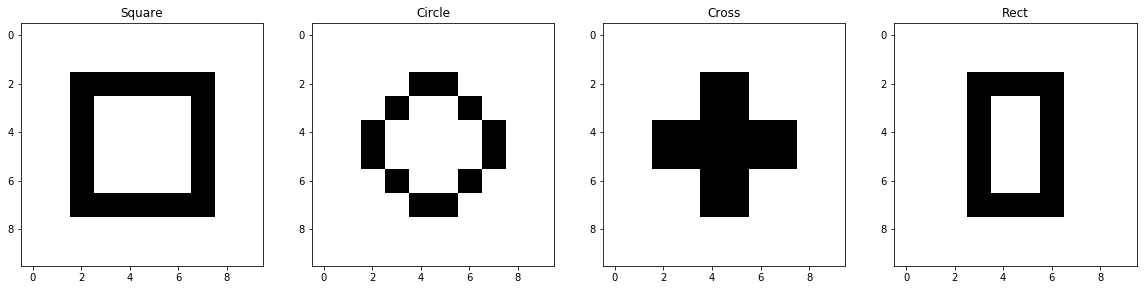

In [3]:
shapes = {'Square' : load_shape('square.npy'), 'Circle' : load_shape('circle.npy'), 'Cross' : load_shape('cross.npy'), 'Rect' : load_shape('rectangle.npy')}

plt.figure(figsize=(20,10))
for i, shape in enumerate(shapes.items()):
    subplot = plt.subplot(1, 4, i + 1)
    subplot.set_title(shape[0])
    plt.imshow(shape[1], cmap=cm.gray_r)

In order to make our dataset realistic, here's a function that randomly offsets a shape:

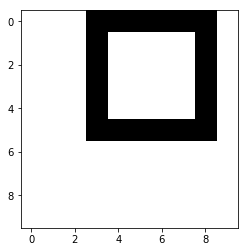

In [4]:
def random_offset(image, min_x, max_x, min_y, max_y):
    x_offset = np.random.randint(min_x, max_x + 1)
    y_offset = np.random.randint(min_y, max_y)
    return np.roll(np.roll(image, x_offset, axis=1), y_offset, axis=0)

plt.imshow(random_offset(shapes['Square'], -2, 2, -2, 2), cmap=cm.gray_r)

Here's another function that adds random noise to the image:

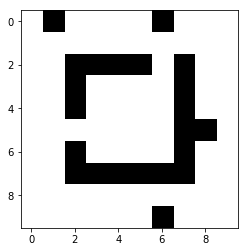

In [5]:
def add_noise(image, probability):
    mask = np.random.random(image.shape) < probability
    return image ^ mask

plt.imshow(add_noise(shapes['Square'], 0.1), cmap=cm.gray_r)

Using our 4 shape matrices and the two functions defined above, we can create an entire dataset of images:

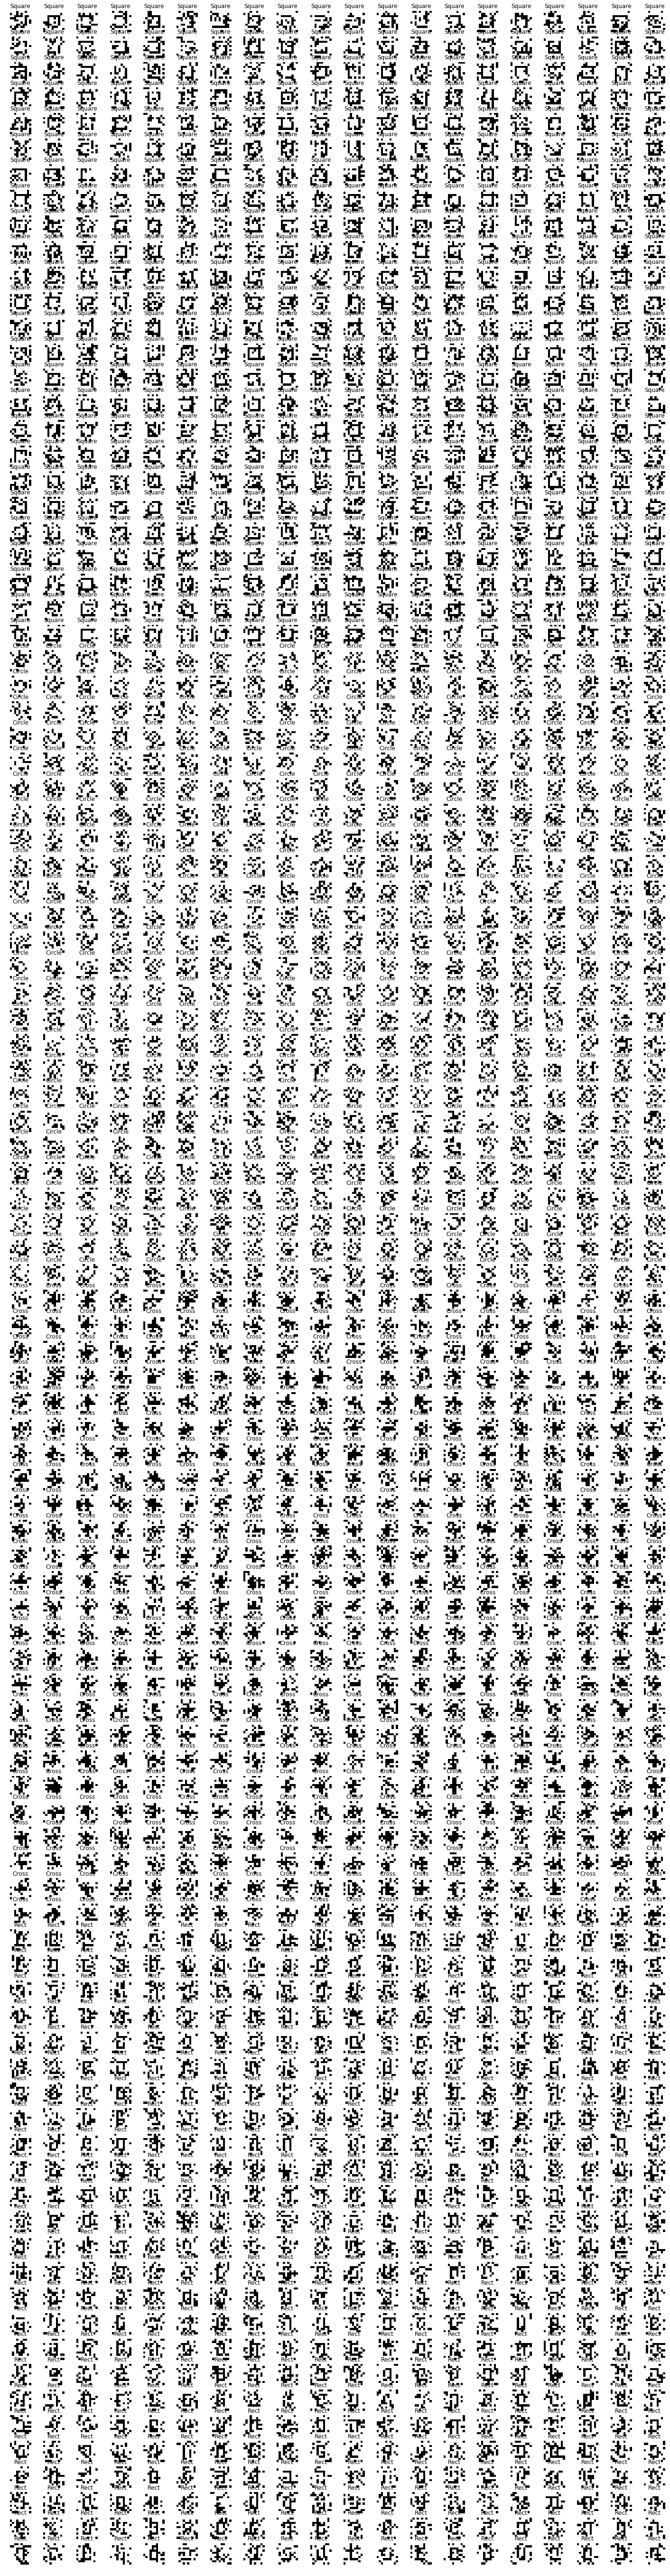

In [20]:
images = []
labels = []

number_of_images_per_class = 500
noise_probability = 0.2

for shape in shapes.items():
    for i in range(1, number_of_images_per_class + 1):
        images.append(add_noise(shape[1], noise_probability))
        labels.append(shape[0])
        
data = pd.DataFrame({'images' : images, 'labels' : labels})

#Display what we just created..
columns = 20
plt.rcParams['figure.figsize'] = [25, 100]
fig = plt.figure()
for i, image in enumerate(images):
    subplot = fig.add_subplot((len(images)/columns)+1, columns, i + 1)
    subplot.set_title(labels[i])
    subplot.axis('off')
    subplot.imshow(images[i], cmap=cm.gray_r)
    
plt.rcParams['figure.figsize'] = [5, 5]

Our goal is going to be to create a neural network that is able to predict which class a particular image belongs to. Next we need to split our data into a training set, a validation set and test set. 

As the name suggests, the training set will be used to train our algorithm and the validation set will be used to see how well our algorithm has trained. 

As we will see, there are various hyper-parameters that can't be learnt, but instead have to be manually set by us (such as the number of layers in our network), when these adjustments are made we'll have to re-train the network on the training data, and test it again against the validation set. 

Once we are happy with the performance of our network on both the training and validation set, we'll then run it against the test set. 

The idea here is to ensure that the algorithm never sees the test data during the training/adjusting phase so we can ensure we don't overfit the data.

In [21]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(data['images'], data['labels']):
    train_set = data.iloc[train_index]
    test_set = data.iloc[test_index]
    
print("Training Data:\n", train_set['labels'].value_counts())
print("\nTest Data:\n", test_set['labels'].value_counts())

Training Data:
 Circle    400
Cross     400
Rect      400
Square    400
Name: labels, dtype: int64

Test Data:
 Cross     100
Rect      100
Square    100
Circle    100
Name: labels, dtype: int64


Now we need to split our training data..

In [22]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, validation_index in split.split(train_set['images'], train_set['labels']):
    new_train_set = train_set.iloc[train_index] 
    validation_set = train_set.iloc[validation_index]

train_set = new_train_set
print("Training Data:\n", train_set['labels'].value_counts())
print("\nValidation Data:\n", validation_set['labels'].value_counts())

Training Data:
 Cross     300
Rect      300
Square    300
Circle    300
Name: labels, dtype: int64

Validation Data:
 Cross     100
Rect      100
Square    100
Circle    100
Name: labels, dtype: int64


We will now create a fully connected neural network with two hidden layers. Typically when doing image classification we would use use much more sophisticated architectures such as CNNs, but sake of this introduction we are going to keep it simple. 

In [23]:
X = tf.placeholder(tf.float32, shape=(None, 100))
y = tf.placeholder(tf.int64, shape=(None))

hidden_layer_1 = tf.layers.dense(X, 100, activation=tf.nn.relu)
hidden_layer_2 = tf.layers.dense(hidden_layer_1, 50, activation=tf.nn.relu)
logits = tf.layers.dense(hidden_layer_2, 4)

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(cross_entropy)

optimizer = tf.train.GradientDescentOptimizer(0.01)
training_optimizer = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

We will now train our neural network against our data. You can see in the code below we process the data in a number of smaller batches. This isn't strictly necessary with the relatively amount of data we are dealing with here, however with typical production scale data, this is how it would be done.

Final validation accuracy:  0.98


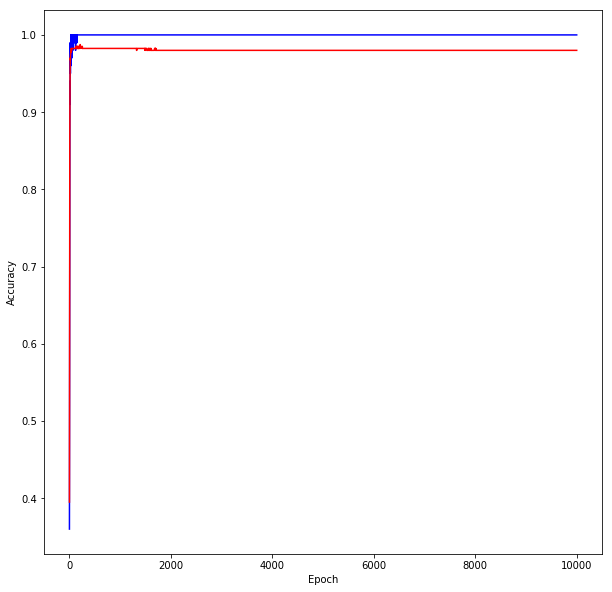

In [24]:
def next_batch(batch_size, images, labels):
    indexes = np.arange(0 , len(images))
    np.random.shuffle(indexes)
    indexes = indexes[:batch_size]
    data_shuffled = [images[index] for index in indexes]
    labels_shuffled = [labels[index] for index in indexes]

    return np.asarray(data_shuffled), np.asarray(labels_shuffled)

label_encodings = {'Square' : 0, 'Cross' : 1, 'Circle' : 2, 'Rect' : 3}
flattened_training_set = [image.flatten() for image in train_set['images'].as_matrix()]
encoded_training_labels = train_set['labels'].replace(label_encodings).as_matrix()

flattened_validation_data = [image.flatten() for image in test_set['images'].as_matrix()]
encoded_validation_labels = test_set['labels'].replace(label_encodings).as_matrix()

number_of_epochs = 10000
batch_size = 100

testing_accuracy = []
training_accuracy = []

with tf.Session() as session:
    init.run()
    for epoch in range(number_of_epochs):
        for iteration in range(len(images) // batch_size):
            X_batch, y_batch = next_batch(batch_size, flattened_training_set, encoded_training_labels)
            session.run(training_optimizer, feed_dict={X: X_batch, y: y_batch})
        training_accuracy.append(accuracy.eval(feed_dict={X: X_batch, y: y_batch}))
        testing_accuracy.append(accuracy.eval(feed_dict={X: flattened_validation_data, y: encoded_validation_labels}))

    save_path = saver.save(session, "./checkpoints/model_final.ckpt")
        
plt.figure(figsize=(10,10))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(training_accuracy, "b-")
plt.plot(testing_accuracy, "r-")
print("Final validation accuracy: ", testing_accuracy.pop())

Now our network is trained. As you can see it is performing slightly better on the training data, than the validation data. feel free to try running it against individual examples from the test set to see what it outputs:

INFO:tensorflow:Restoring parameters from ./checkpoints/model_final.ckpt
Prediction:  Circle


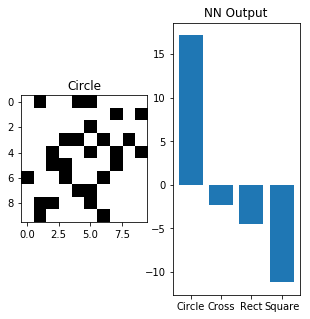

In [25]:
test_index = 233 #Change this to run on different test examples

flattened_test_set = [image.flatten() for image in test_set['images'].as_matrix()]
encoded_test_labels = test_set['labels'].replace(label_encodings).as_matrix()

test_image = [flattened_test_set[test_index]]
test_label = encoded_test_labels[test_index]

with tf.Session() as session:
    saver.restore(session, "./checkpoints/model_final.ckpt")
    Z = logits.eval(feed_dict={X: test_image})
    y_prediction = np.argmax(Z, axis=1)

#Display image and output bar chart:
image = plt.subplot(1, 2, 1)
image.set_title(list(label_encodings.keys())[list(label_encodings.values()).index(test_label)])
image.imshow(test_set['images'].as_matrix()[test_index], cmap=cm.gray_r)
graph = plt.subplot(1, 2, 2)
graph.set_title("NN Output")
graph.bar(['Square', 'Cross', 'Circle', 'Rect'], Z.flatten())
print("Prediction: ", list(label_encodings.keys())[list(label_encodings.values()).index(y_prediction)])

We can analyise the performance of our network by calculating its Precision, Recall and F1 score. We can also plot a confusion matrix.

INFO:tensorflow:Restoring parameters from ./checkpoints/model_final.ckpt
Confusion matrix:
[[100   0   0   0]
 [  1  97   2   0]
 [  0   0  98   2]
 [  1   0   2  97]]
Precision:  0.9802436125965538
Recall:  0.98
F1 Score:  0.9800104962668295


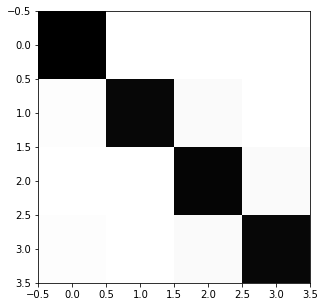

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

flattened_test_set = [image.flatten() for image in test_set['images'].as_matrix()]
encoded_test_labels = test_set['labels'].replace(label_encodings).as_matrix()

with tf.Session() as session:
    saver.restore(session, "./checkpoints/model_final.ckpt")
    predictions = []
    for image in flattened_test_set:
        Z = logits.eval(feed_dict={X: [image]})
        predictions.append(np.argmax(Z, axis=1))

print("Confusion matrix:")
print(confusion_matrix(encoded_test_labels, predictions))
plt.imshow(confusion_matrix(encoded_test_labels, predictions), cmap=cm.gray_r)
print("Precision: ", precision_score(encoded_test_labels, predictions, average='weighted'))
print("Recall: ", recall_score(encoded_test_labels, predictions, average='weighted'))
print("F1 Score: ", f1_score(encoded_test_labels, predictions, average='weighted'))
